In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.impute import SimpleImputer
from google.colab import files

In [3]:
# Step 1: Load and preprocess data
print("Please upload the 'matches.csv' file:")
uploaded = files.upload()
# Read the matches dataset
matches_df = pd.read_csv('matches.csv')

print("\nPlease upload the 'deliveries.csv' file:")
uploaded = files.upload()
# Read the deliveries dataset
deliveries_df = pd.read_csv('deliveries.csv')

# Display basic information about the datasets
print(f"\nMatches dataset shape: {matches_df.shape}")
print("\nFirst few rows of matches dataset:")
print(matches_df.head())

print(f"\nDeliveries dataset shape: {deliveries_df.shape}")
print("\nFirst few rows of deliveries dataset:")
print(deliveries_df.head())

# Handle column name discrepancies - ensure we're working with standardized column names
# Rename id to match_id in matches if needed
if 'id' in matches_df.columns and 'match_id' not in matches_df.columns:
    matches_df.rename(columns={'id': 'match_id'}, inplace=True)

Please upload the 'matches.csv' file:


Saving matches.csv to matches (1).csv

Please upload the 'deliveries.csv' file:


Saving deliveries.csv to deliveries (1).csv

Matches dataset shape: (1095, 20)

First few rows of matches dataset:
       id   season        city        date match_type player_of_match  \
0  335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1  335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2  335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3  335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4  335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kol

In [4]:
# Step 2: Extract match statistics from deliveries data
print("\nExtracting match statistics from deliveries data...")

# Group deliveries by match_id to calculate various statistics
match_stats = deliveries_df.groupby('match_id').agg({
    'total_runs': 'sum',
    'is_wicket': lambda x: sum(x == 1) if 'is_wicket' in deliveries_df.columns else 0,
    'batsman_runs': 'sum',
    'extra_runs': 'sum'
}).reset_index()

# Calculate boundaries and dot balls
boundaries = deliveries_df[deliveries_df['batsman_runs'].isin([4, 6])].groupby('match_id').size().reset_index(name='boundaries')
dot_balls = deliveries_df[deliveries_df['batsman_runs'] == 0].groupby('match_id').size().reset_index(name='dot_balls')

# Merge stats with boundaries and dot balls
match_stats = pd.merge(match_stats, boundaries, on='match_id', how='left')
match_stats = pd.merge(match_stats, dot_balls, on='match_id', how='left')

# Calculate wickets per match
if 'is_wicket' in deliveries_df.columns:
    wickets = deliveries_df[deliveries_df['is_wicket'] == 1].groupby('match_id').size().reset_index(name='wickets')
    match_stats = pd.merge(match_stats, wickets, on='match_id', how='left')
else:
    # If is_wicket column doesn't exist, use player_dismissed
    wickets = deliveries_df.groupby('match_id')['player_dismissed'].apply(
        lambda x: x.str.strip().ne('').sum()).reset_index(name='wickets')
    match_stats = pd.merge(match_stats, wickets, on='match_id', how='left')

# Fill any missing values
match_stats.fillna(0, inplace=True)

# Calculate team-wise statistics from deliveries
batting_stats = deliveries_df.groupby(['match_id', 'batting_team']).agg({
    'batsman_runs': 'sum',
    'total_runs': 'sum'
}).reset_index()

bowling_stats = deliveries_df.groupby(['match_id', 'bowling_team']).agg({
    'is_wicket': lambda x: sum(x == 1) if 'is_wicket' in deliveries_df.columns else 0,
}).reset_index()

# Merge the stats back to matches dataset
matches_with_stats = pd.merge(matches_df, match_stats, on='match_id', how='left')


Extracting match statistics from deliveries data...


In [5]:
# Step 3: Feature Engineering
print("\nEngineering additional features...")

# Extract team data for team performance metrics
team_names = pd.concat([matches_df['team1'], matches_df['team2']]).unique()
team_encoder = LabelEncoder()
team_encoder.fit(team_names)

# Convert date column to datetime for temporal analysis
if 'date' in matches_df.columns:
    matches_df['date'] = pd.to_datetime(matches_df['date'])

# Create features dataframe
features_df = matches_df.copy()

# Initialize feature columns
features_df['team1_win_rate'] = 0.0
features_df['team2_win_rate'] = 0.0
features_df['win_rate_diff'] = 0.0
features_df['team1_venue_win_rate'] = 0.0
features_df['team2_venue_win_rate'] = 0.0
features_df['toss_win_rate'] = 0.0
features_df['h2h_win_rate'] = 0.0
features_df['team1_home_adv'] = 0.0
features_df['team2_home_adv'] = 0.0

# Track team performances over time
team_performances = {team: {'matches': 0, 'wins': 0} for team in team_names}
venue_performances = {}
toss_win_rates = []

# Process matches chronologically for time-based features
if 'date' in matches_df.columns:
    sorted_matches = matches_df.sort_values('date')
else:
    sorted_matches = matches_df.sort_values('match_id')

# Iterate through matches to build cumulative features
for idx, match in sorted_matches.iterrows():
    match_id = match['match_id']
    team1 = match['team1']
    team2 = match['team2']
    venue = match['venue']
    toss_winner = match['toss_winner']
    winner = match['winner'] if pd.notna(match['winner']) else None

    # Skip if needed data is missing
    if pd.isna(team1) or pd.isna(team2):
        continue

    # Calculate team win rates
    if team_performances[team1]['matches'] > 0:
        team1_win_rate = team_performances[team1]['wins'] / team_performances[team1]['matches']
    else:
        team1_win_rate = 0.0

    if team_performances[team2]['matches'] > 0:
        team2_win_rate = team_performances[team2]['wins'] / team_performances[team2]['matches']
    else:
        team2_win_rate = 0.0

    # Update feature dataframe
    features_df.loc[idx, 'team1_win_rate'] = team1_win_rate
    features_df.loc[idx, 'team2_win_rate'] = team2_win_rate
    features_df.loc[idx, 'win_rate_diff'] = team1_win_rate - team2_win_rate

    # Venue performance
    if venue not in venue_performances:
        venue_performances[venue] = {team: {'matches': 0, 'wins': 0} for team in team_names}

    # Team1 venue performance
    if venue_performances[venue][team1]['matches'] > 0:
        team1_venue_win_rate = venue_performances[venue][team1]['wins'] / venue_performances[venue][team1]['matches']
    else:
        team1_venue_win_rate = 0.0

    # Team2 venue performance
    if venue_performances[venue][team2]['matches'] > 0:
        team2_venue_win_rate = venue_performances[venue][team2]['wins'] / venue_performances[venue][team2]['matches']
    else:
        team2_venue_win_rate = 0.0

    features_df.loc[idx, 'team1_venue_win_rate'] = team1_venue_win_rate
    features_df.loc[idx, 'team2_venue_win_rate'] = team2_venue_win_rate

    # City as home advantage (assuming teams have home cities)
    city = match['city'] if 'city' in match and pd.notna(match['city']) else None
    if city:
        # Simplistic home advantage - teams often associated with their city
        features_df.loc[idx, 'team1_home_adv'] = 1 if team1.lower() in city.lower() else 0
        features_df.loc[idx, 'team2_home_adv'] = 1 if team2.lower() in city.lower() else 0

    # Toss win rate impact
    if len(toss_win_rates) > 0:
        toss_advantage = sum(toss_win_rates) / len(toss_win_rates)
    else:
        toss_advantage = 0.5  # Default 50% advantage

    features_df.loc[idx, 'toss_win_rate'] = toss_advantage

    # Head-to-head win rate
    h2h_matches = matches_df[((matches_df['team1'] == team1) & (matches_df['team2'] == team2) |
                              (matches_df['team1'] == team2) & (matches_df['team2'] == team1)) &
                             (matches_df['match_id'] < match_id)]

    team1_h2h_wins = len(h2h_matches[h2h_matches['winner'] == team1])
    team2_h2h_wins = len(h2h_matches[h2h_matches['winner'] == team2])
    total_h2h = len(h2h_matches)

    if total_h2h > 0:
        h2h_win_rate = (team1_h2h_wins - team2_h2h_wins) / total_h2h  # Positive if team1 has advantage
    else:
        h2h_win_rate = 0.0

    features_df.loc[idx, 'h2h_win_rate'] = h2h_win_rate

    # Update team performance after match
    if winner:
        # Update toss win rate (did toss winner win the match?)
        toss_win_rates.append(1 if toss_winner == winner else 0)

        # Update team stats
        team_performances[team1]['matches'] += 1
        team_performances[team2]['matches'] += 1

        if winner == team1:
            team_performances[team1]['wins'] += 1
        elif winner == team2:
            team_performances[team2]['wins'] += 1

        # Update venue stats
        venue_performances[venue][team1]['matches'] += 1
        venue_performances[venue][team2]['matches'] += 1

        if winner == team1:
            venue_performances[venue][team1]['wins'] += 1
        elif winner == team2:
            venue_performances[venue][team2]['wins'] += 1



Engineering additional features...


In [6]:
# Step 4: Add categorical encodings
print("\nAdding categorical encodings...")

# Identify categorical columns that need encoding
categorical_cols = ['city', 'match_type', 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner']
encoders = {}

for col in categorical_cols:
    if col in features_df.columns:
        le = LabelEncoder()
        # Fit on non-null values only
        non_null_values = features_df[col].dropna()
        if len(non_null_values) > 0:
            le.fit(non_null_values)
            # Transform and handle NaN values
            features_df[f'{col}_encoded'] = features_df[col].map(
                lambda x: le.transform([x])[0] if pd.notna(x) and x in le.classes_ else -1)
            encoders[col] = le

# Encode team1 being toss winner
features_df['team1_toss_winner'] = (features_df['toss_winner'] == features_df['team1']).astype(int)

# Encode toss decision (1 for bat, 0 for field)
if 'toss_decision' in features_df.columns:
    features_df['toss_decision_bat'] = (features_df['toss_decision'] == 'bat').astype(int)

# Add date-based features
if 'date' in features_df.columns:
    features_df['year'] = features_df['date'].dt.year
    features_df['month'] = features_df['date'].dt.month
    features_df['day_of_week'] = features_df['date'].dt.dayofweek



Adding categorical encodings...


In [7]:
# Step 5: Prepare features for model training
print("\nPreparing final feature set...")

# Define the target variable
features_df['target'] = (features_df['winner'] == features_df['team1']).astype(int)

# Select features for model training
numeric_features = [
    'team1_win_rate', 'team2_win_rate', 'win_rate_diff',
    'team1_venue_win_rate', 'team2_venue_win_rate',
    'toss_win_rate', 'h2h_win_rate',
    'team1_home_adv', 'team2_home_adv',
    'team1_toss_winner'
]

# Add encoded categorical features
encoded_features = [col for col in features_df.columns if col.endswith('_encoded')]

# Add date features if available
date_features = []
if 'date' in features_df.columns:
    date_features = ['year', 'month', 'day_of_week']

# Add toss decision if available
if 'toss_decision_bat' in features_df.columns:
    numeric_features.append('toss_decision_bat')

# Combine all features
all_features = numeric_features + encoded_features + date_features

# Filter to keep only columns that exist in the dataframe
selected_features = [feat for feat in all_features if feat in features_df.columns]

# Create feature matrix and target vector
X = features_df[selected_features].copy()
y = features_df['target'].copy()

# Drop rows with NaN values in target or too many NaNs in features
valid_mask = ~y.isna() & (X.isna().sum(axis=1) < len(X.columns) / 2)
X = X[valid_mask]
y = y[valid_mask]

# Fill remaining NaN values
X = X.fillna(X.mean())

# Print final feature set
print(f"\nFinal feature set shape: {X.shape}")
print("Selected features:")
print(X.columns.tolist())



Preparing final feature set...

Final feature set shape: (1095, 22)
Selected features:
['team1_win_rate', 'team2_win_rate', 'win_rate_diff', 'team1_venue_win_rate', 'team2_venue_win_rate', 'toss_win_rate', 'h2h_win_rate', 'team1_home_adv', 'team2_home_adv', 'team1_toss_winner', 'toss_decision_bat', 'city_encoded', 'match_type_encoded', 'venue_encoded', 'team1_encoded', 'team2_encoded', 'toss_winner_encoded', 'toss_decision_encoded', 'winner_encoded', 'year', 'month', 'day_of_week']


In [8]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



--- Random Forest Model ---

Random Forest Accuracy: 0.7664

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.71      0.86      0.77       128
           1       0.85      0.68      0.76       146

    accuracy                           0.77       274
   macro avg       0.78      0.77      0.77       274
weighted avg       0.78      0.77      0.77       274



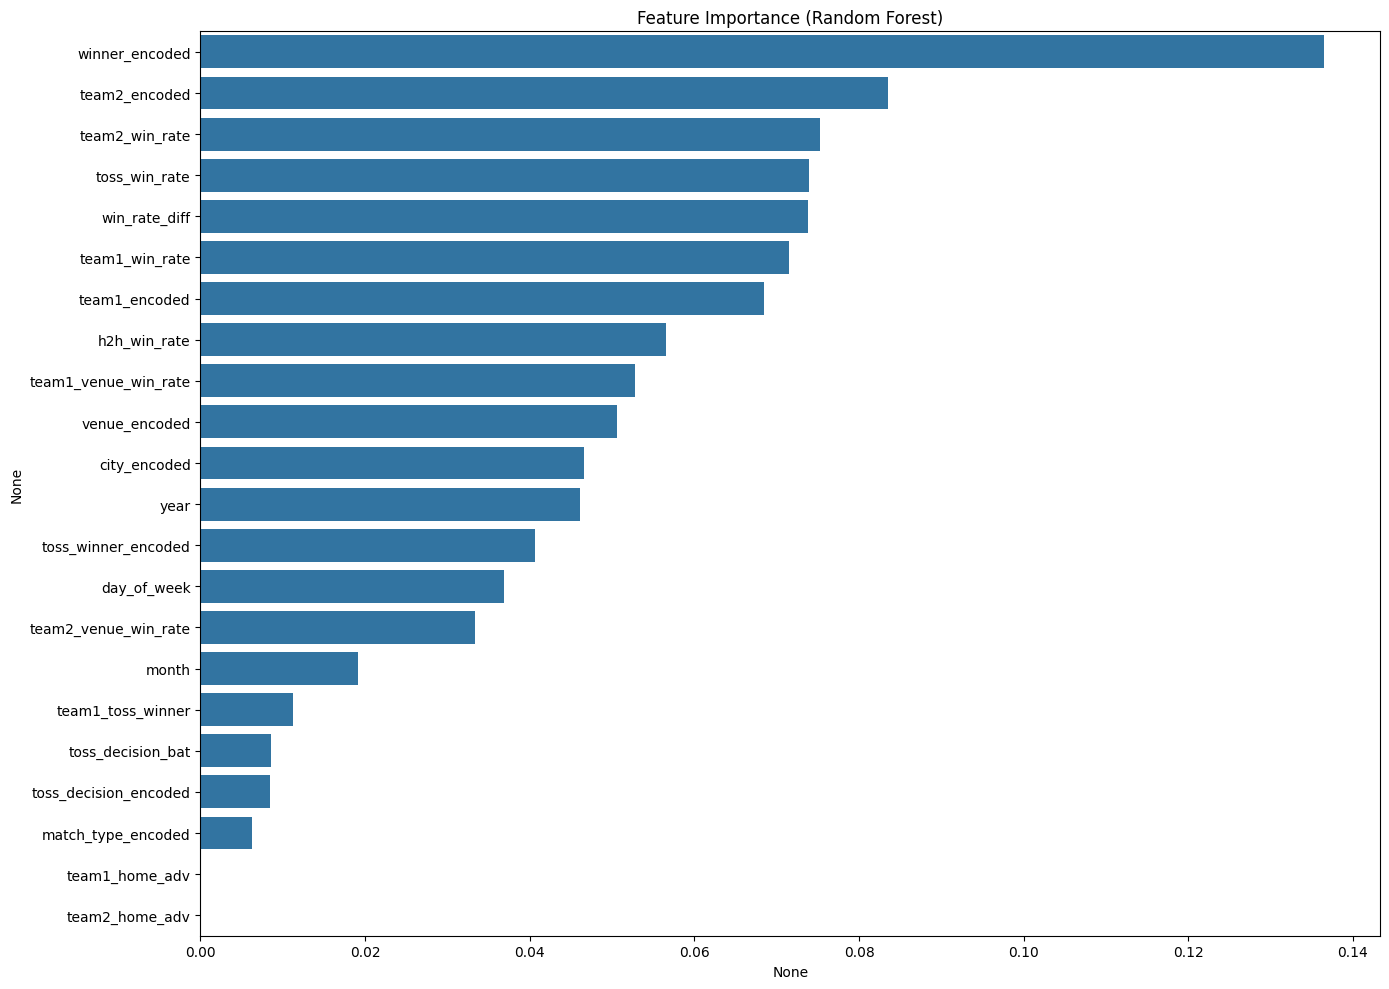

In [9]:
# Step 7: Build and evaluate Random Forest model
print("\n--- Random Forest Model ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_preds))

# Feature importance
plt.figure(figsize=(14, 10))
feature_imp = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()



--- XGBoost Model ---

XGBoost Accuracy: 0.8796

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       128
           1       0.94      0.83      0.88       146

    accuracy                           0.88       274
   macro avg       0.88      0.88      0.88       274
weighted avg       0.89      0.88      0.88       274



<Figure size 1400x1000 with 0 Axes>

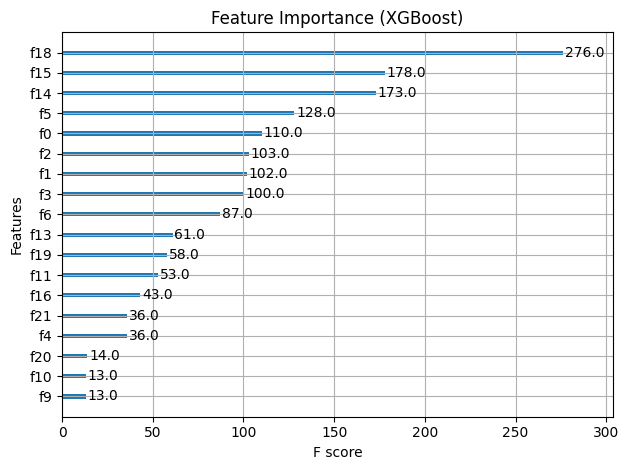

In [10]:
# Step 8: Build and evaluate XGBoost model
print("\n--- XGBoost Model ---")
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=0.1,
                              n_estimators=100,
                              max_depth=5,
                              random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"\nXGBoost Accuracy: {xgb_accuracy:.4f}")
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, xgb_preds))

# XGBoost feature importance
plt.figure(figsize=(14, 10))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


In [11]:
# Step 9: Hyperparameter tuning with GridSearchCV
print("\n--- Random Forest Hyperparameter Tuning ---")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                     rf_param_grid,
                     cv=5,
                     scoring='accuracy',
                     n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Evaluate best Random Forest model
best_rf = rf_grid.best_estimator_
best_rf_preds = best_rf.predict(X_test_scaled)
best_rf_accuracy = accuracy_score(y_test, best_rf_preds)
print(f"Best Random Forest Test Accuracy: {best_rf_accuracy:.4f}")

# For XGBoost
print("\n--- XGBoost Hyperparameter Tuning ---")
xgb_param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42),
                      xgb_param_grid,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

# Evaluate best XGBoost model
best_xgb = xgb_grid.best_estimator_
best_xgb_preds = best_xgb.predict(X_test_scaled)
best_xgb_accuracy = accuracy_score(y_test, best_xgb_preds)
print(f"Best XGBoost Test Accuracy: {best_xgb_accuracy:.4f}")



--- Random Forest Hyperparameter Tuning ---
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.7978
Best Random Forest Test Accuracy: 0.8066

--- XGBoost Hyperparameter Tuning ---
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9257
Best XGBoost Test Accuracy: 0.9015



--- Model Comparison ---


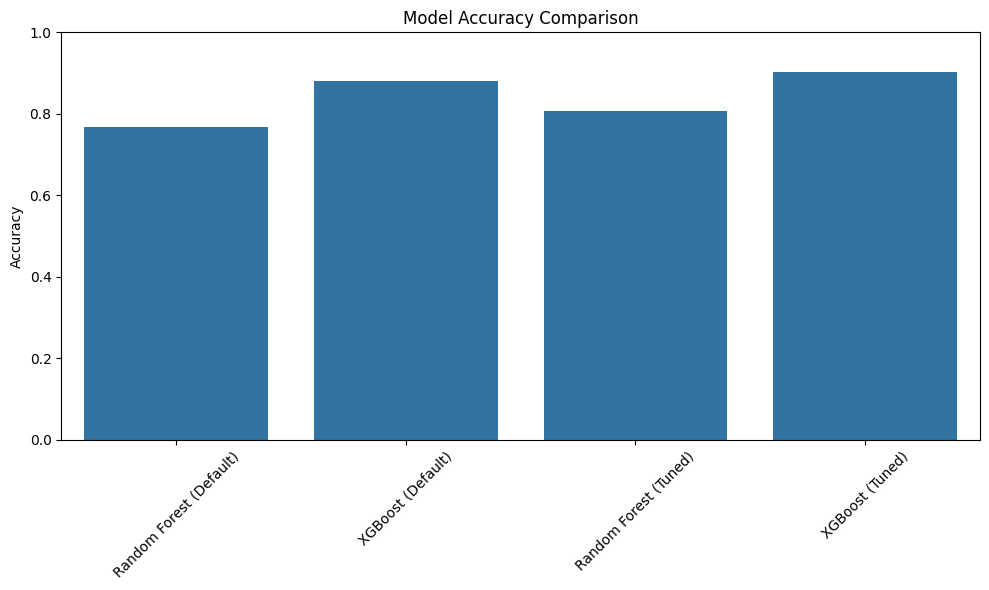

In [12]:
# Step 10: Compare models
print("\n--- Model Comparison ---")
models = ['Random Forest (Default)', 'XGBoost (Default)',
          'Random Forest (Tuned)', 'XGBoost (Tuned)']
accuracies = [rf_accuracy, xgb_accuracy, best_rf_accuracy, best_xgb_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Step 11: Save the best model
import pickle

# Choose the best model
if best_rf_accuracy > best_xgb_accuracy:
    best_model = best_rf
    model_name = 'random_forest'
else:
    best_model = best_xgb
    model_name = 'xgboost'

# Save model and associated components
with open(f'best_ipl_predictor_{model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('feature_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nBest model ({model_name}) saved as 'best_ipl_predictor_{model_name}.pkl'")
print("Feature encoders saved as 'feature_encoders.pkl'")
print("Feature scaler saved as 'feature_scaler.pkl'")



Best model (xgboost) saved as 'best_ipl_predictor_xgboost.pkl'
Feature encoders saved as 'feature_encoders.pkl'
Feature scaler saved as 'feature_scaler.pkl'


In [14]:
# Step 12: Create a function for predicting future matches
def predict_match_winner(team1, team2, venue, city, toss_winner, toss_decision):
    """
    Predict the winner of a future IPL match

    Parameters:
    team1 (str): First team name
    team2 (str): Second team name
    venue (str): Match venue
    city (str): Match city
    toss_winner (str): Team that won the toss
    toss_decision (str): Toss decision (bat/field)

    Returns:
    Predicted winner and confidence score
    """
    # Create a dataframe for the prediction
    pred_data = pd.DataFrame({
        'team1': [team1],
        'team2': [team2],
        'venue': [venue],
        'city': [city],
        'toss_winner': [toss_winner],
        'toss_decision': [toss_decision]
    })

    # Load saved components
    with open(f'best_ipl_predictor_{model_name}.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('feature_encoders.pkl', 'rb') as f:
        encoders = pickle.load(f)

    with open('feature_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # Create features
    pred_features = pd.DataFrame()

    # Use the latest match data for these features
    # (In a real application, you would calculate these from the most recent match data)
    pred_features['team1_win_rate'] = [features_df['team1_win_rate'].iloc[-1]]
    pred_features['team2_win_rate'] = [features_df['team2_win_rate'].iloc[-1]]
    pred_features['win_rate_diff'] = [features_df['win_rate_diff'].iloc[-1]]
    pred_features['team1_venue_win_rate'] = [features_df['team1_venue_win_rate'].iloc[-1]]
    pred_features['team2_venue_win_rate'] = [features_df['team2_venue_win_rate'].iloc[-1]]
    pred_features['toss_win_rate'] = [features_df['toss_win_rate'].iloc[-1]]
    pred_features['h2h_win_rate'] = [features_df['h2h_win_rate'].iloc[-1]]

    # Team1 home advantage
    pred_features['team1_home_adv'] = [1 if team1.lower() in city.lower() else 0]
    pred_features['team2_home_adv'] = [1 if team2.lower() in city.lower() else 0]

    # Team1 won toss
    pred_features['team1_toss_winner'] = [1 if toss_winner == team1 else 0]

    # Toss decision
    pred_features['toss_decision_bat'] = [1 if toss_decision == 'bat' else 0]

    # Encode categorical features
    for col in encoders:
        if col in pred_data.columns:
            le = encoders[col]
            try:
                value = pred_data[col].iloc[0]
                if value in le.classes_:
                    pred_features[f'{col}_encoded'] = le.transform([value])
                else:
                    pred_features[f'{col}_encoded'] = [-1]  # Unknown value
            except:
                pred_features[f'{col}_encoded'] = [-1]  # Error handling

    # Ensure all features used by the model are present
    for feat in X.columns:
        if feat not in pred_features.columns:
            pred_features[feat] = 0  # Default value

    # Keep only columns used during training
    pred_features = pred_features[X.columns]

    # Scale features
    pred_features_scaled = scaler.transform(pred_features)

    # Make prediction
    prediction = model.predict(pred_features_scaled)[0]
    probabilities = model.predict_proba(pred_features_scaled)[0]

    # Determine winner and confidence
    if prediction == 1:
        winner = team1
        confidence = probabilities[1] * 100
    else:
        winner = team2
        confidence = probabilities[0] * 100

    return winner, confidence

# Example usage (commented out)
"""
predicted_winner, confidence = predict_match_winner(
    team1='Mumbai Indians',
    team2='Chennai Super Kings',
    venue='Wankhede Stadium',
    city='Mumbai',
    toss_winner='Mumbai Indians',
    toss_decision='bat'
)

print(f"Predicted winner: {predicted_winner} with {confidence:.2f}% confidence")
"""

print("\nMachine learning pipeline completed successfully!")
print("You can now use the 'predict_match_winner' function to predict future match outcomes.")


Machine learning pipeline completed successfully!
You can now use the 'predict_match_winner' function to predict future match outcomes.


In [17]:
predicted_winner, confidence = predict_match_winner(
    team1='Gujrat Titans',
    team2='Sunrisers Hyderabad',
    venue='Narendra Modi Stadium, Ahmedabad',
    city='Ahmedabad',
    toss_winner='Sunrisers Hyderabad',
    toss_decision='Bowl'
)

print(f"Predicted winner: {predicted_winner} with {confidence:.2f}% confidence")

Predicted winner: Gujrat Titans with 99.62% confidence
